In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = os.path.join("/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png")
mask_path = os.path.join("/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/masks")
image_files = sorted(os.listdir(image_path))
mask_files = sorted(os.listdir(mask_path))

In [2]:
# Filtrando para garantir correspondência
filtered_image_files = []
filtered_mask_files = []

# Criando conjuntos de nomes de arquivos sem extensão para comparação
image_names = set([os.path.splitext(f)[0] for f in image_files])
mask_names = set([os.path.splitext(f)[0].replace('_mask', '') for f in mask_files])

# Iterando sobre os nomes das imagens e adicionando apenas os que têm correspondência
for img_file in image_files:
    img_name = os.path.splitext(img_file)[0]
    if img_name in mask_names:
        filtered_image_files.append(img_file)

# Iterando sobre os nomes das máscaras e adicionando apenas os que têm correspondência
for mask_file in mask_files:
    mask_name = os.path.splitext(mask_file)[0].replace('_mask', '')
    if mask_name in image_names:
        filtered_mask_files.append(mask_file)

# Verificando se o número de arquivos de imagem e máscara é o mesmo após a filtragem
assert len(filtered_image_files) == len(filtered_mask_files), "Número de imagens e máscaras não corresponde após a filtragem!"

print(f"Número de imagens filtradas: {len(filtered_image_files)}")
print(f"Número de máscaras filtradas: {len(filtered_mask_files)}")

# Função para carregar e redimensionar as imagens
def load_data(image_files, mask_files, image_path, mask_path, img_size=(256, 256)):
    images = []
    masks = []
    for img_file, mask_file in zip(image_files, mask_files):
        img = load_img(os.path.join(image_path, img_file), target_size=img_size)
        mask = load_img(os.path.join(mask_path, mask_file), target_size=img_size, color_mode="grayscale")
        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

# Carregando os dados
images, masks = load_data(filtered_image_files, filtered_mask_files, image_path, mask_path)

Número de imagens filtradas: 704
Número de máscaras filtradas: 704


In [3]:
# Definindo o bloco convolucional
def conv_block(inputs, num_filters):
	# Applying the sequence of Convolutional, Batch Normalization
	# and Activation Layers to the input tensor
	x = tf.keras.Sequential([
		# Convolutional Layer
		tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
		# Batch Normalization Layer
		tf.keras.layers.BatchNormalization(),
		# Activation Layer
		tf.keras.layers.Activation('relu'),
		# Convolutional Layer
		tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
		# Batch Normalization Layer
		tf.keras.layers.BatchNormalization(),
		# Activation Layer
		tf.keras.layers.Activation('relu')
	])(inputs)

	# Returning the output of the Convolutional Block
	return x


In [4]:
# Defining the Unet++ Model
def unet_plus_plus_model(input_shape=(256, 256, 3), num_classes=1, deep_supervision=True):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Caminho de Codificação
    x_00 = conv_block(inputs, 32)  # Reduzido de 64 para 32
    x_10 = conv_block(tf.keras.layers.MaxPooling2D()(x_00), 64)  # Reduzido de 128 para 64
    x_20 = conv_block(tf.keras.layers.MaxPooling2D()(x_10), 128)  # Reduzido de 256 para 128
    x_30 = conv_block(tf.keras.layers.MaxPooling2D()(x_20), 256)  # Reduzido de 512 para 256
    x_40 = conv_block(tf.keras.layers.MaxPooling2D()(x_30), 512)  # Reduzido de 1024 para 512

    # Caminho de Decodificação Aninhado
    x_01 = conv_block(tf.keras.layers.concatenate([x_00, tf.keras.layers.UpSampling2D()(x_10)]), 32)
    x_11 = conv_block(tf.keras.layers.concatenate([x_10, tf.keras.layers.UpSampling2D()(x_20)]), 64)
    x_21 = conv_block(tf.keras.layers.concatenate([x_20, tf.keras.layers.UpSampling2D()(x_30)]), 128)
    x_31 = conv_block(tf.keras.layers.concatenate([x_30, tf.keras.layers.UpSampling2D()(x_40)]), 256)

    x_02 = conv_block(tf.keras.layers.concatenate([x_00, x_01, tf.keras.layers.UpSampling2D()(x_11)]), 32)
    x_12 = conv_block(tf.keras.layers.concatenate([x_10, x_11, tf.keras.layers.UpSampling2D()(x_21)]), 64)
    x_22 = conv_block(tf.keras.layers.concatenate([x_20, x_21, tf.keras.layers.UpSampling2D()(x_31)]), 128)

    x_03 = conv_block(tf.keras.layers.concatenate([x_00, x_01, x_02, tf.keras.layers.UpSampling2D()(x_12)]), 32)
    x_13 = conv_block(tf.keras.layers.concatenate([x_10, x_11, x_12, tf.keras.layers.UpSampling2D()(x_22)]), 64)

    x_04 = conv_block(tf.keras.layers.concatenate([x_00, x_01, x_02, x_03, tf.keras.layers.UpSampling2D()(x_13)]), 32)

    # Caminho de Supervisão Profunda
    if deep_supervision:
        outputs = [
            tf.keras.layers.Conv2D(num_classes, 1)(x_01),
            tf.keras.layers.Conv2D(num_classes, 1)(x_02),
            tf.keras.layers.Conv2D(num_classes, 1)(x_03),
            tf.keras.layers.Conv2D(num_classes, 1)(x_04)
        ]
        outputs = tf.keras.layers.concatenate(outputs, axis=0)
    else:
        outputs = tf.keras.layers.Conv2D(num_classes, 1)(x_04)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
    return model


# Testing the model
if __name__ == "__main__":
	# Creating the model
	model = unet_plus_plus_model(input_shape=(
		512, 512, 3), num_classes=2, deep_supervision=True)

	# Printing the model summary
	model.summary()


Model: "Unet_plus_plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 512, 512,  │     10,400 │ input_layer[0][0] │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ sequential[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 256, 256,  │     55,936 │ max_pooling2d[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ sequential_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 128, 128,  │    222,464 │ max_pooling2d_1[… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ sequential_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    887,296 │ max_pooling2d_2[… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ sequential_3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 32, 32,    │  3,544,064 │ max_pooling2d_3[… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ sequential_4[0][… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ sequential_3[0][… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 768)              │            │ up_sampling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ sequential_2[0][… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 384)              │            │ up_sampling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64, 64,    │  2,361,856 │ concatenate_3[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 512, 512,  │          0 │ sequential_1[0][

 Total params: 9,170,856 (34.98 MB)

 Trainable params: 9,163,560 (34.96 MB)

 Non-trainable params: 7,296 (28.50 KB)

In [5]:
from sklearn.model_selection import train_test_split

# Dividindo os dados
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [6]:
# Definindo o modelo
model = unet_plus_plus_model(input_shape=(256, 256, 3), num_classes=1, deep_supervision=False)

# Compilando o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
# Treinando o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=36,
    batch_size=16,
)

Epoch 1/36


I0000 00:00:1724460089.017274     125 service.cc:145] XLA service 0x7803140034f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724460089.017335     125 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724460089.017340     125 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-08-24 00:41:52.110606: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,192,256,256]{3,2,1,0}, f32[32,192,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-24 00:41:52.290876: E

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8180 - loss: 0.9304   

2024-08-24 00:44:11.222758: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[13,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,192,256,256]{3,2,1,0}, f32[32,192,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-24 00:44:11.285334: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.06268533s
Trying algorithm eng0{} for conv (f32[13,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,192,256,256]{3,2,1,0}, f32[32,192,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0"

36/36 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.8201 - loss: 0.9168 - val_accuracy: 0.7547 - val_loss: 1.5798
Epoch 2/36
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 844ms/step - accuracy: 0.9559 - loss: 0.1410 - val_accuracy: 0.8481 - val_loss: 0.4614
Epoch 3/36
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 836ms/step - accuracy: 0.9091 - loss: 0.2630 - val_accuracy: 0.3741 - val_loss: 8.7319
Epoch 4/36
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 841ms/step - accuracy: 0.8758 - loss: 0.2643 - val_accuracy: 0.8625 - val_loss: 0.7518
Epoch 5/36
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 844ms/step - accuracy: 0.9304 - loss: 0.2110 - val_accuracy: 0.8301 - val_loss: 0.4074
Epoch 6/36
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 848ms/step - accuracy: 0.8651 - loss: 0.3396 - val_accuracy: 0.6822 - val_loss: 3.9344
Epoch 7/36
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 837ms/step - accuracy: 0.8943 - loss: 0.2710 - val_accuracy: 0.7160 - val_loss: 1.8381
Epoch 8/36
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 844ms/step - accuracy: 0.9482 - loss: 0.1515 - val_accuracy: 0.8345 

In [18]:
model.save('/kaggle/working/modelo_unet_plusplus.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


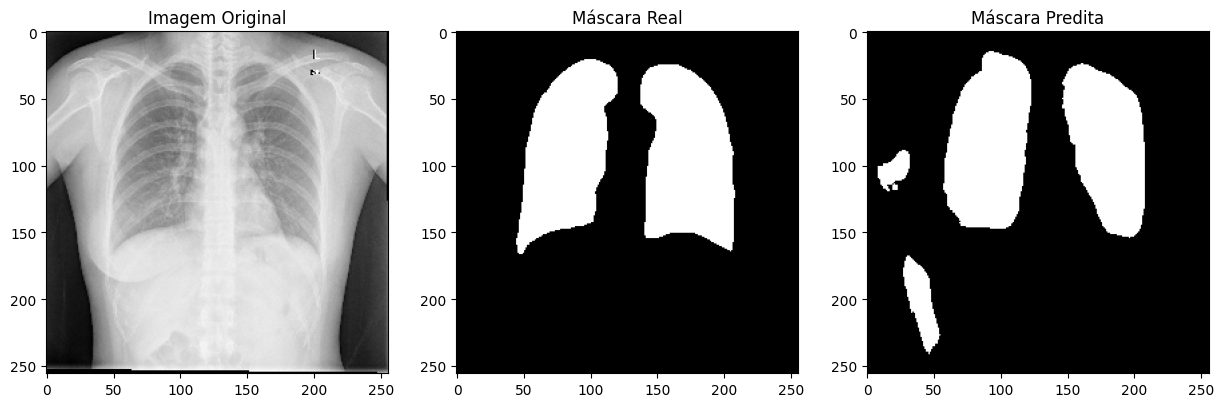

Imagem 1:
Dice Similarity: 0.7878851467142307
Fitness Adjust:  0.6500086560101563
Size Adjust:     0.9781415031651104
Position Adjust: 0.987189769777513
IoU:             0.6500086560101563




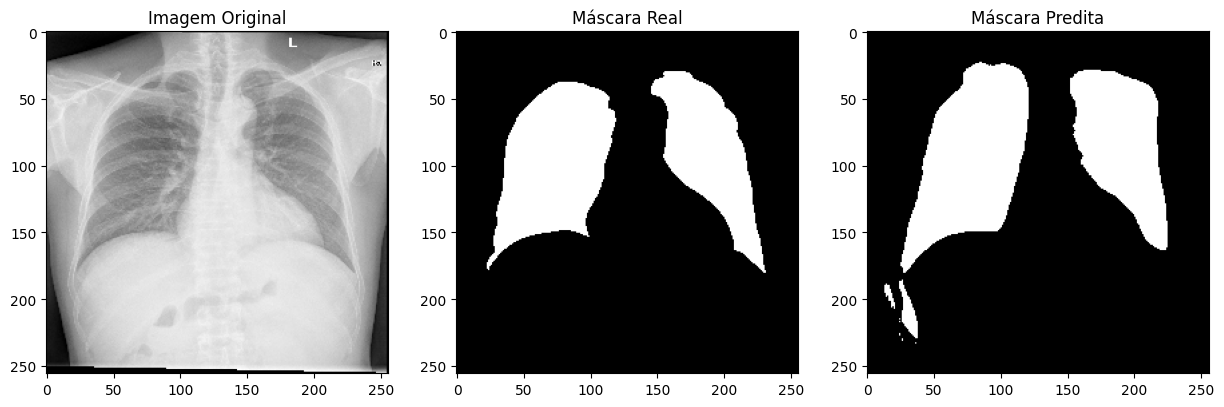

Imagem 2:
Dice Similarity: 0.8828506569443489
Fitness Adjust:  0.7902709359605912
Size Adjust:     0.9475132420719543
Position Adjust: 0.9965843090194046
IoU:             0.7902709359605912




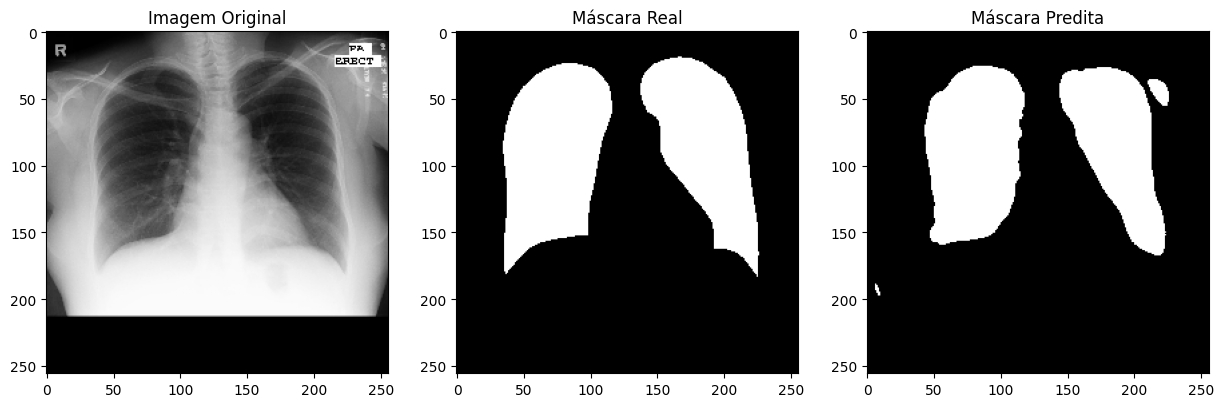

Imagem 3:
Dice Similarity: 0.8764281611029553
Fitness Adjust:  0.780037493609044
Size Adjust:     0.9264058211527414
Position Adjust: 0.9939920008789298
IoU:             0.780037493609044




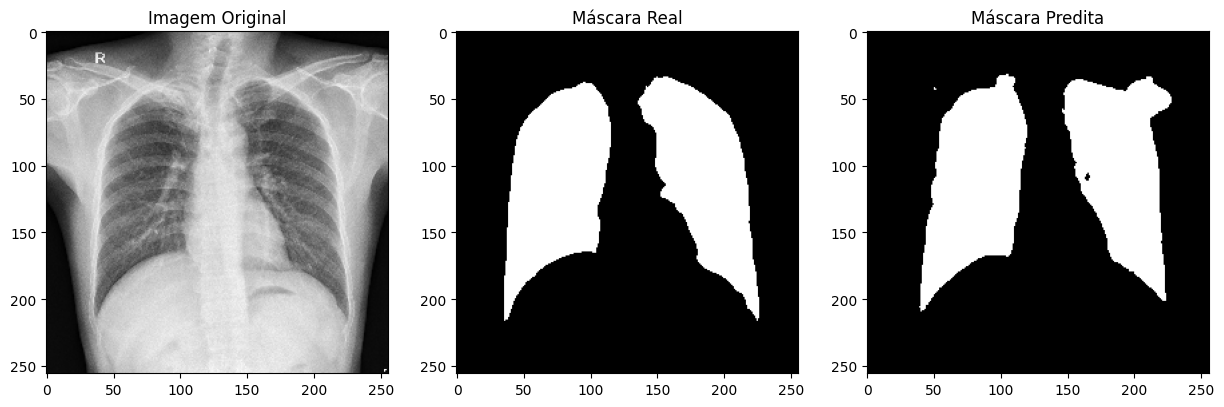

Imagem 4:
Dice Similarity: 0.8892198084559683
Fitness Adjust:  0.8005362494085484
Size Adjust:     0.993225881803317
Position Adjust: 0.9881442611934609
IoU:             0.8005362494085484




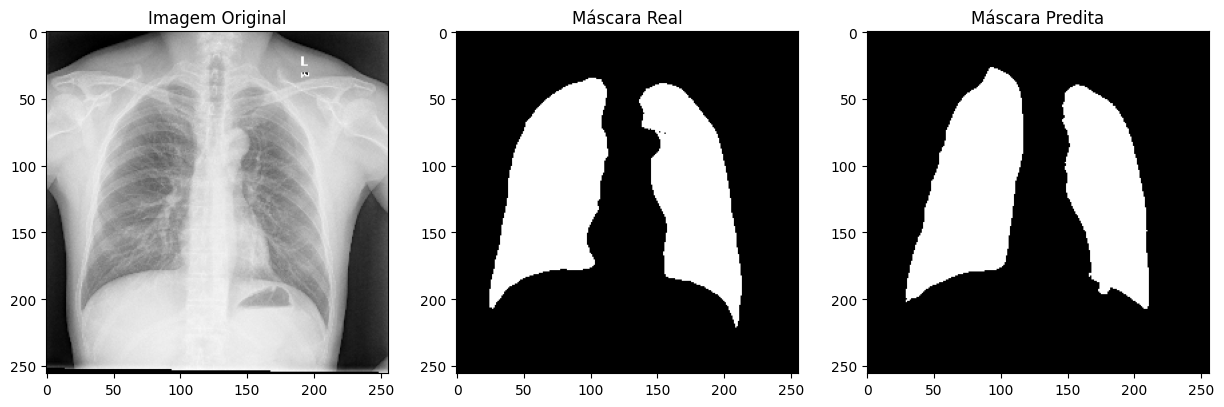

Imagem 5:
Dice Similarity: 0.8999252950844165
Fitness Adjust:  0.8180583473678492
Size Adjust:     0.9737337516808606
Position Adjust: 0.9954593322145358
IoU:             0.8180583473678492




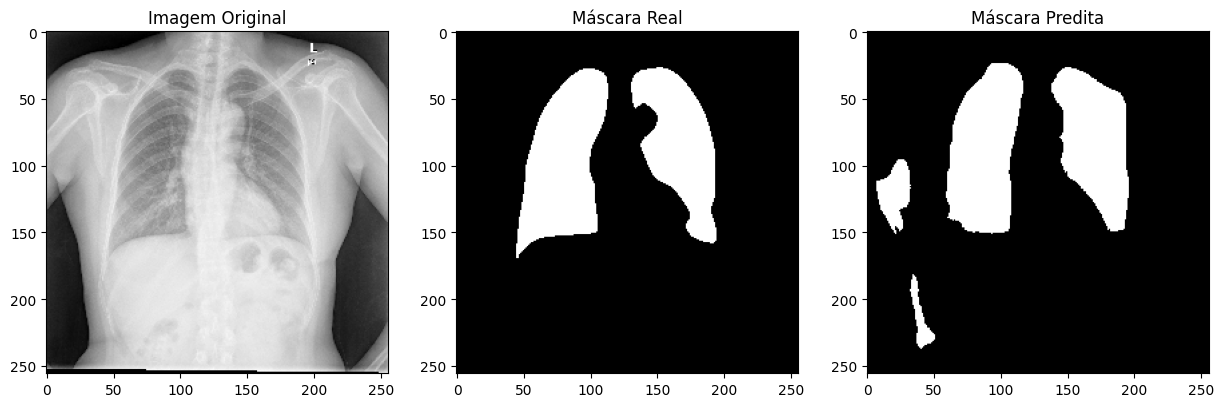

Imagem 6:
Dice Similarity: 0.8167983743508692
Fitness Adjust:  0.6903289825204183
Size Adjust:     0.9786407766990292
Position Adjust: 0.9933658897388697
IoU:             0.6903289825204183




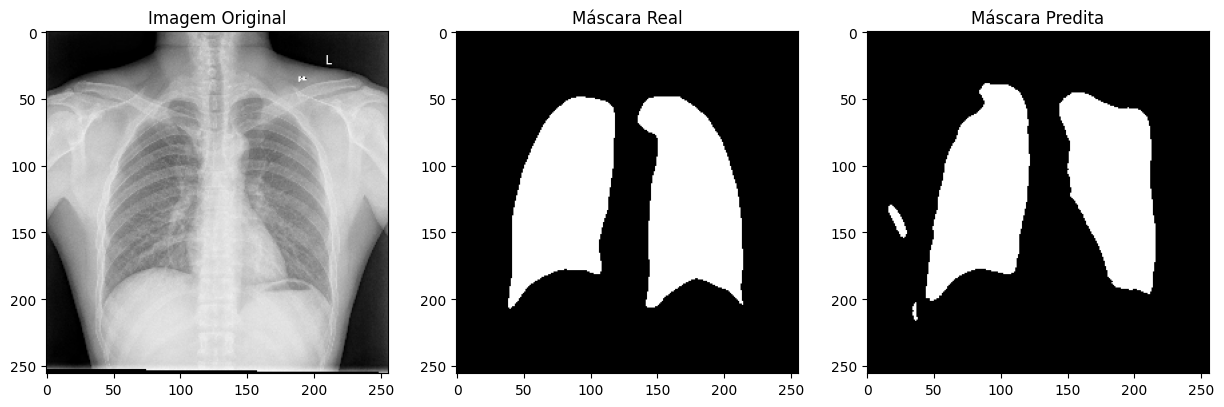

Imagem 7:
Dice Similarity: 0.8390009027986759
Fitness Adjust:  0.7226542249870399
Size Adjust:     0.9633463737586518
Position Adjust: 0.9875842742504379
IoU:             0.7226542249870399




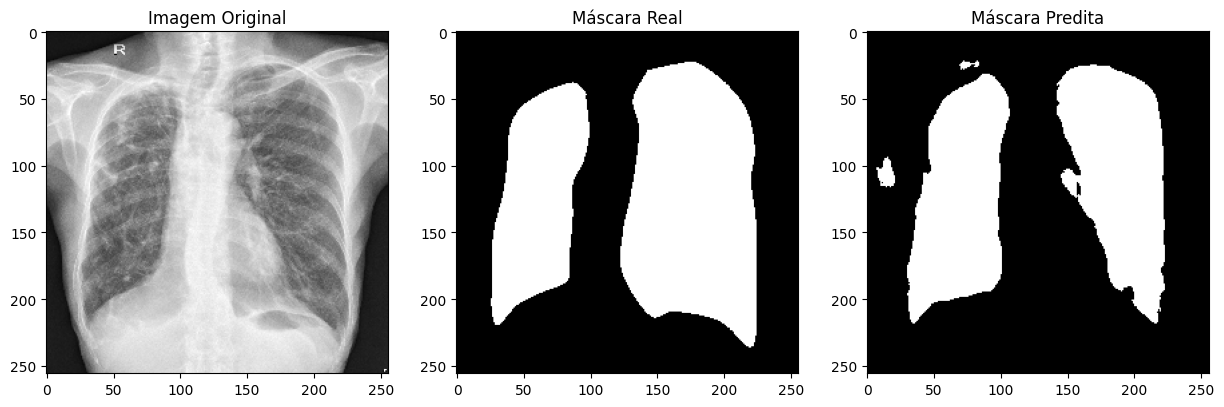

Imagem 8:
Dice Similarity: 0.7881995661605206
Fitness Adjust:  0.6504367750250608
Size Adjust:     0.8845119305856833
Position Adjust: 0.9760786515679101
IoU:             0.6504367750250608




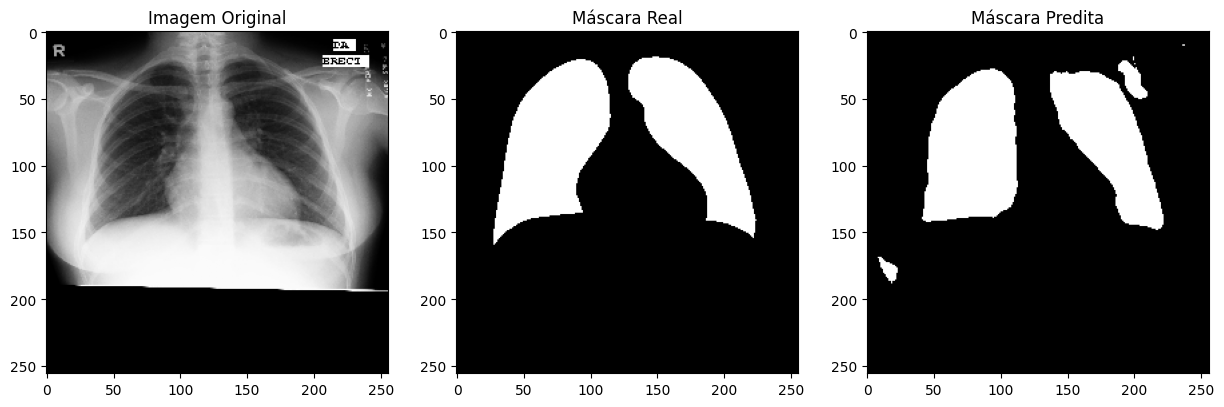

Imagem 9:
Dice Similarity: 0.8430839538273648
Fitness Adjust:  0.7287339099639039
Size Adjust:     0.9585943347910019
Position Adjust: 0.9887528345931965
IoU:             0.7287339099639039




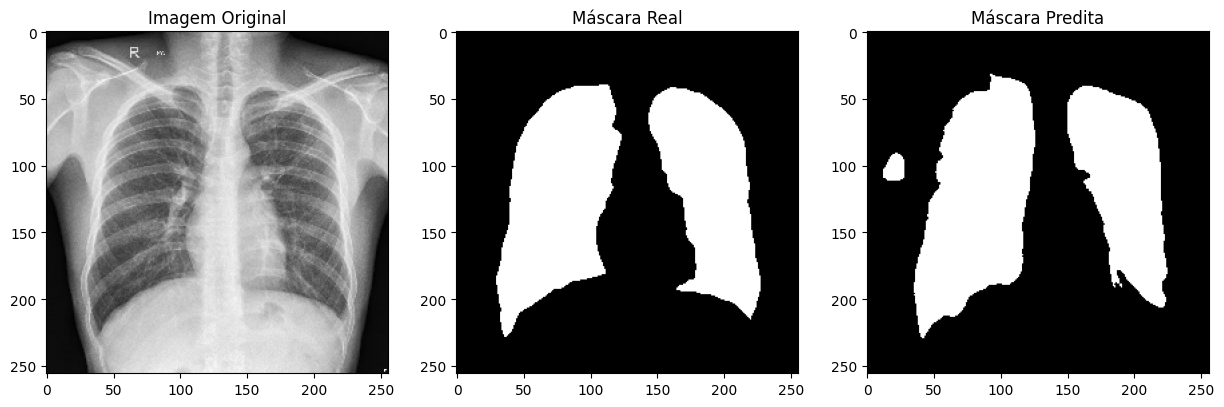

Imagem 10:
Dice Similarity: 0.8842325557654025
Fitness Adjust:  0.7924882199551672
Size Adjust:     0.9970394568934715
Position Adjust: 0.9967973279691346
IoU:             0.7924882199551672




In [22]:
# Funções de métrica
def compute_fit_adjust(array, arrayRef):
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    imor = np.bitwise_or(array.astype("uint8"), arrayRef.astype("uint8"))
    sumand = np.sum(imand)
    sumor = np.sum(imor)
    result = (sumand / float(sumor))
    return result

def compute_size_adjust(array, arrayRef):
    imArea1 = np.count_nonzero(arrayRef)
    imArea2 = np.count_nonzero(array)
    subArea = np.abs(imArea1 - imArea2)
    sumArea = imArea1 + imArea2
    result = (1 - subArea / sumArea)
    return result

def compute_position_adjust(arraySeg, arrayRef):
    indsSeg = np.where(arraySeg > 0)
    indsRef = np.where(arrayRef > 0)
    centroidRefY = indsRef[0].mean()
    centroidRefX = indsRef[1].mean()
    centroidSegY = indsSeg[0].mean()
    centroidSegX = indsSeg[1].mean()
    subCentroidY = np.abs(centroidSegY - centroidRefY) / arrayRef.shape[0]
    subCentroidX = np.abs(centroidSegX - centroidRefX) / arrayRef.shape[1]
    result = 1 - (subCentroidY + subCentroidX) / 3
    return result

def compute_dice_similarity(array, arrayRef):
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    imor = np.bitwise_or(array.astype("uint8"), arrayRef.astype("uint8"))
    sumand = 2 * np.sum(imand)
    sumor = np.sum(array) + np.sum(arrayRef)
    result = (sumand / float(sumor))
    return result

def compute_iou(array, arrayRef):
    """
    Esta função calcula o Intersection over Union (IoU) e retorna o valor calculado.

    Arguments:
        array {numpy.array} -- array 2D com o conteúdo segmentado
        arrayRef {numpy.array} -- array 2D com o conteúdo de referência

    Returns:
        float -- valor do IoU entre 0 e 1.
    """
    intersection = np.logical_and(array, arrayRef)
    union = np.logical_or(array, arrayRef)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Número de imagens de validação que você deseja selecionar aleatoriamente
num_samples = 10

# Selecionando índices aleatórios
random_indices = np.random.choice(len(X_val), num_samples, replace=False)

# Selecionando as imagens de validação aleatórias
random_val_images = X_val[random_indices]
random_val_masks = y_val[random_indices]

# Fazendo predições nas imagens de validação aleatórias
pred_masks = model.predict(random_val_images)

# Binarizando as máscaras preditas
pred_masks = (pred_masks > 0.7).astype(np.uint8)

# Exibindo as imagens, máscaras reais e máscaras preditas
for i in range(num_samples):
    plt.figure(figsize=(15, 5))
    
    # Imagem original
    plt.subplot(1, 3, 1)
    plt.imshow(random_val_images[i])
    plt.title("Imagem Original")
    
    # Máscara Real
    plt.subplot(1, 3, 2)
    plt.imshow(random_val_masks[i].squeeze(), cmap='gray')
    plt.title("Máscara Real")
    
    # Máscara Predita
    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i].squeeze(), cmap='gray')
    plt.title("Máscara Predita")
    
    plt.show()
    
    # Calculando as métricas
    res_dice = compute_dice_similarity(pred_masks[i], random_val_masks[i])
    res_fit = compute_fit_adjust(pred_masks[i], random_val_masks[i])
    res_size = compute_size_adjust(pred_masks[i], random_val_masks[i])
    res_pos = compute_position_adjust(pred_masks[i], random_val_masks[i])
    res_iou = compute_iou(pred_masks[i], random_val_masks[i])
    
    print(f"Imagem {i+1}:")
    print(f"Dice Similarity: {res_dice}")
    print(f"Fitness Adjust:  {res_fit}")
    print(f"Size Adjust:     {res_size}")
    print(f"Position Adjust: {res_pos}")
    print(f"IoU:             {res_iou}")
    print("\n")
